In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import GPy

In [2]:
from BayesOptimiser import BayesOptimiser

## Motivation
In this notebook, we will perform Bayesian optimisation on the Forrester function.

Bayesian Optimisation is a sequential model-based approach to black-box optimisation. At the start, a probabilistic model is trained with an initial set of samples from the target function. In a sequential manner, the algorithm draws samples from the function, where the choice of sampling is driven by the maximisation of an acquisition function. The algorithm terminates when the optimum has been found. 

A Bayesian Optimiser has two key ingredients:
1. A *probabilistic model* that is used to model the target function
2. An *acquisition function* that balances exploration and exploitation

### 1. Probabilistic model
In black-box optimisation, the function that we wish to optimise is usually unknown or extremely costly to evaluate. Hence, we train a probabilistic model to act as a surrogate during optimisation. In particular, we typically prescribe a *Gaussian Process* prior, and perform Bayesian posterior updates by sampling the target function at selected points. Note that the goal here is NOT to obtain a complete model of the function. Instead, our goal is only to find its optimal value. 

### 2. Acquisition function
The acquisition function guides the choice of sampling in a way that "intelligently" balances exploitation and exploration. The goal here is to discover the optimum with the least number of function evaluations possible. More on the acquisition function later...

## Our target function
Here, we will use the Forrester function, a simple 1-dimensional problem. Remember that, the actual function is unknown to us and it is costly to evaluate.

In [3]:
from benchmark_problems import forrester

In [4]:
def init_data():
    X_train = np.array([0, 0.18, 0.25, 0.28, 0.5, 0.95, 1])
    Y_train = forrester(X_train)
    
    n_test = 200
    X_test = np.linspace(0, 1, n_test)
    Y_test = forrester(X_test)
    return X_train.reshape(-1,1), Y_train.reshape(-1,1), X_test.reshape(-1,1), Y_test.reshape(-1,1)

In [5]:
X_train, Y_train, X_test, Y_test = init_data()

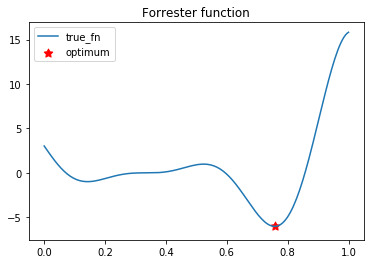

Optimum point: x = 0.76
Optimum value: y = -6.02


In [6]:
min_index = np.argmin(Y_test); 
X_min = X_test[min_index,0]; Y_min = Y_test[min_index,0];
plt.plot(X_test, Y_test, label='true_fn')
plt.scatter(X_min, Y_min, s=80, c="r", marker=(5, 1),label='optimum')
plt.title("Forrester function"); plt.legend(); plt.show();
print("Optimum point: x = {:.2f}".format(X_min))
print("Optimum value: y = {:.2f}".format(Y_min))

## Our probabilistic model
Here, we will use a Gaussian Process with a squared exponential kernel. The Matérn kernel is also commonly used.

In [7]:
def init_regression_model(X_train, Y_train):
    k = GPy.kern.RBF(1,variance=np.exp(0), lengthscale=1) 
    m = GPy.models.GPRegression(X_train, Y_train, k, noise_var=np.exp(-4))
    m.optimize(max_iters = 1000) # Train model on initial data
    return m

In [8]:
m = init_regression_model(X_train, Y_train)
display(m)

In [9]:
# Some helper functions for plotting
def add_confidence_bounds(ax, x, mu, s):
    ax.fill_between(np.squeeze(x), np.squeeze(mu-2*s), np.squeeze(mu+2*s), facecolor='grey', alpha=0.2)

def remove_confidence_bounds(ax):
    for coll in (ax.collections): ax.collections.remove(coll)

## Our acquisition function
Having trained our probabilistic model on the initial samples from our target function, we can visualise the acquisition function induced on the design space. The next sample point will be chosen by maximising this acquisition function.

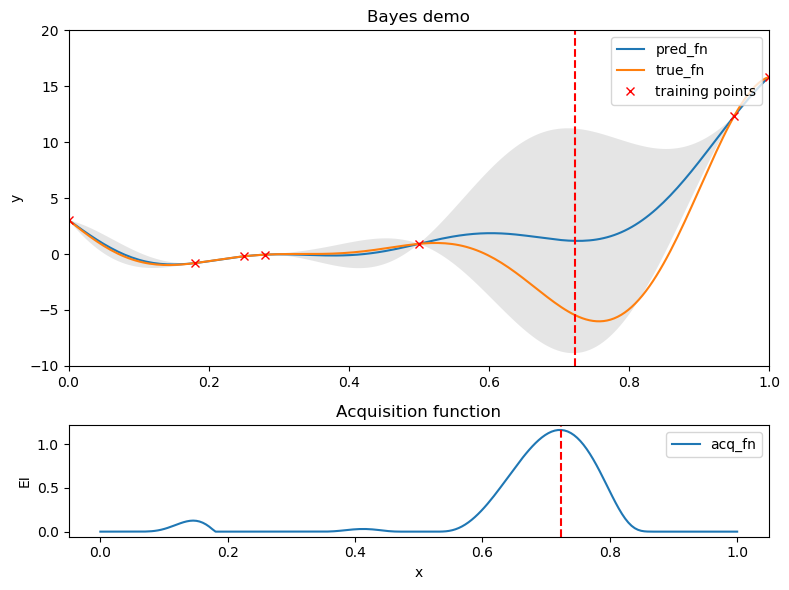

In [10]:
# Initialise BayesianOptimiser
BO = BayesOptimiser(model=m, objective=forrester, X_init=X_train, Y_init=Y_train)
acq, X_new = BO.suggest_next_location_1D(X_test)
mu_test, s_test = BO.predict_with_model(X_test)

## TODO: Create a class for sequential plotting!
# Initialise plot
fig,(ax0,ax1) = plt.subplots(2,1, figsize=(8, 6), gridspec_kw = {'height_ratios':[3, 1]}, dpi=100)
ax0.set_xlim(0,1); ax0.set_ylim(-10,20);
ax0.set_title('Bayes demo'); ax0.set_ylabel('y')
ax1.set_title('Acquisition function'); ax1.set_ylabel('EI'); ax1.set_xlabel('x');

line_post, = ax0.plot(X_test, mu_test, label="pred_fn")
line_true, = ax0.plot(X_test, Y_test, label="true_fn")
line_next1 = ax0.axvline(X_new, color='r', linestyle="dashed")
pts_train, = ax0.plot(BO.X, BO.Y,'rx', label="training points")
add_confidence_bounds(ax0, X_test, mu_test, s_test)
ax0.legend(handles=[line_post, line_true, pts_train],loc="upper right")

line_acq, = ax1.plot(X_test, acq, label="acq_fn")
line_next2 = ax1.axvline(X_new, color='r', linestyle="dashed")
ax1.legend(); plt.tight_layout(); plt.show()

Here we will use the Expected Improvement criterion as our acquistion function. Intuitively, it is a measure of the expected improvement in the currently found optimum that may be acheived by sampling at a given point $x$.

Notice that there are two peaks in the acquisition function, corresponding to:
1. __Exploitation__: we can sample at the small peak at $x = 0.15$ if we exploit the locally optimum region which has been discovered.
2. __Exploration__: or we can sample at the larger peak at $x = 0.72$ if we explore the uncertain region that is currently undersampled.

In this instance, the acquisition function has chosen exploration over exploitation. Hence, the algorithm will sample at the second peak, which guides the optimisation in the correct direction. On the other hand, a purely exploitative strategy would have gotten stuck in the local optimum.

## Putting it altogether

In [11]:
# Code to create animation
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"

def single_update_bayes_opt():
    global BO, mu_test, s_test, acq, X_new
    BO.process_next_location_1D(X_new)
    mu_test, s_test = BO.predict_with_model(X_test)
    acq, X_new = BO.suggest_next_location_1D(X_test)
    
    updatePlot()

def updatePlot():
    line_post.set_data(X_test,mu_test)
    line_acq.set_data(X_test,acq)
    pts_train.set_data(BO.X, BO.Y)
    line_next1.set_xdata(X_new)
    remove_confidence_bounds(ax0)
    add_confidence_bounds(ax0, X_test, mu_test, s_test)    
    
    line_next2.set_xdata(X_new)
    ax1.relim(); ax1.autoscale_view()
    fig.canvas.draw()
    
def animate(i):
    if i == 0: pass
    else: single_update_bayes_opt()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=5, interval = 2000)

In [12]:
ani